# PCA-like linear autoencoder
* Inspired by PCAAE from Pham et al. paper (https://arxiv.org/abs/2006.07827)
* Desired properties:
    * Decorrelate latent activations $z_i$ to gain better understanding of **intrinsic data attributes**.
    * Order latent components by decreasing relevance allows prioritizing data attributes.

In [1]:
import keras
import keras.backend as K
import matplotlib.pyplot as plt; plt.gray()
%matplotlib inline
import numpy as np; np.random.seed(1)
import tensorflow as tf
from skimage import draw
import dataset

In [2]:
expl_idx = 0
vmin, vmax = -128, 128
nrows, ncols = 64, 64
nsamples = 10_000
ncomponents = 3
batch_size = 256

### 1. Generate data

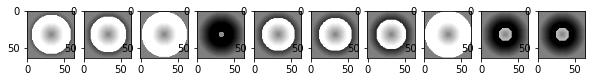

In [4]:
data = dataset.construct(nsamples, nrows, ncols, "circle")
X = data - data.mean(axis=0) # center data: same input data as PCA.

fig, axs = plt.subplots(1, 10, figsize=(10,1))
for (i, ax) in enumerate(axs):
    ax.imshow(tf.reshape(X[i], (nrows, ncols)), vmin=vmin, vmax=vmax)

### 2. Create model
We accomplish the two objectives by:
* Training neurons sequentially.
* Adding term to loss for punishing off-diagonal elements of latent activation covariance matrix.

To ease computation we use a BatchNormalization on each latent activation $z_i$, s.t. its output is of 0 mean and unit variance. We use $cov(z_i, z_j)=E(z_i z_j) - E(z_i)E(z_j)$ with expectation (mean) $E(z_i)=E(z_j)=0$ due to batch normalization. The magnitude of the off-diagonal elements can then be expressed by $\sum_{i<k}\big(E(z_i z_k)\big)^2$ with k-th component (currently under training) of the latent vector $z$. Thus the covariance between the currently trained neuron to every other neuron is only calculated once. 

In [4]:
class CovReg(keras.regularizers.Regularizer):
    def __init__(self, w=1.0):
        self.w = w
    def __call__(self, a):
        acc  = K.sum( K.square(a[-1,:] * a[:-1,:]))
        loss = acc / (a.shape[-1]**2)
        return self.w * loss

def build_encoder(input_layer):
    outputs = keras.layers.Dense(1, use_bias=False)
    bn = keras.layers.BatchNormalization(center=False, scale=False) # no learning
    return keras.Sequential([input_layer, outputs, bn])

def build_decoder(n):
    inputs = keras.layers.Input(shape=(n,))
    outputs = keras.layers.Dense(nrows*ncols, use_bias=False)
    return keras.Sequential([inputs, outputs])

### 3. Train model
* The model is trained one latent neuron at a time.
* After one neuron is trained its weights are fixed and a the next latent neuron is trained.
* The latent activations are concatenated and trained on a free decoder.
* After each (single neuron) training the decoder is discarded and a new one is created.

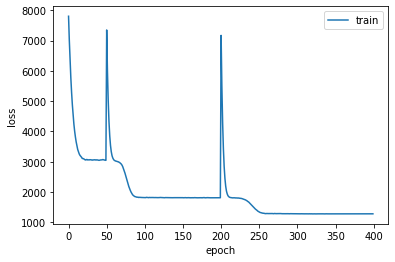

In [5]:
input_layer = keras.layers.Input(shape=(nrows*ncols,))
encoders = []

epochs = [50, 150, 200] # schedule epochs such that learning saturates.
# Notice: each new component saturates later than the previous.
# The loss is larger since more covariances are considered.

for i in range(ncomponents):
    encoders.append( build_encoder(input_layer) ) # same input layer for all encoders
    decoder = build_decoder(n=i+1)  # increase input size of decoder w/ each training
    
    for e in encoders[:i]: 
        e.trainable = False # only train i-th latent neuron
    
    if i >= 1:
        encoded = keras.layers.concatenate([e(input_layer) for e in encoders], 
                                           activity_regularizer=CovReg())
    else:
        encoded = encoders[0](input_layer)  # concatenate needs at least two layers.
    
    pcalae = keras.models.Model(input_layer, decoder(encoded))
    pcalae.compile(loss='mse', optimizer=keras.optimizers.Adam(1e-1)) # BN allows faster training.
    
    if i >= 1:
        pcalae.fit(X, X, epochs=epochs[i], batch_size=batch_size, verbose=0, callbacks=[history])
    else:
        history = pcalae.fit(X, X, epochs=epochs[i], batch_size=batch_size, verbose=0)

plt.plot(history.history['loss'], label='train')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

### 4. Transform into and from latent space

Z_mean = -0.0013283175649121404, Z_var = 1.031475305557251


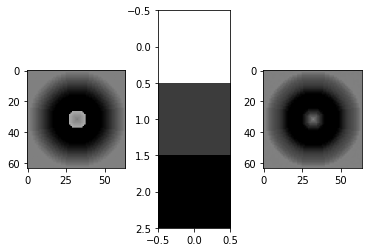

In [6]:
Z = np.array([e.predict(X) for e in encoders], dtype='float32').reshape(nsamples, ncomponents)
print(f"Z_mean = {Z.mean()}, Z_var = {Z.var()}")
X_pred = decoder(Z)

fig, ax = plt.subplots(ncols=3, nrows=1)
ax[0].imshow(tf.reshape(X[expl_idx],(nrows, ncols)), vmin=vmin, vmax=vmax)
ax[1].imshow(tf.reshape(Z[expl_idx], (-1, 1)))
ax[2].imshow(tf.reshape(X_pred[expl_idx], (nrows, ncols)), vmin=vmin, vmax=vmax)

### 5. Interpolation in latent space

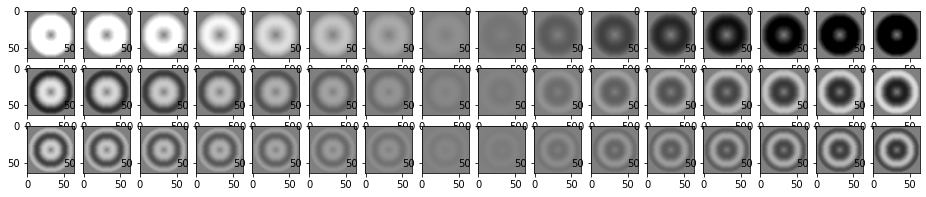

In [7]:
steps = 16
z_vars = [np.linspace(np.min(ax), np.max(ax), steps) for ax in tf.transpose(Z)] # interpolation range
fig, axs = plt.subplots(ncols=steps, nrows=ncomponents, figsize=(steps, ncomponents))

for i in range(ncomponents):
    for j in range(steps):
        z = np.zeros_like(Z[expl_idx]) # ! LAEs latent components are not uncorrelated
        z[i] = z_vars[i][j]
        x_pred = decoder.predict(z.reshape(1, -1))
        ax = list(axs.flat)[j+i*j] if ncomponents==1 else axs[i, j]
        ax.imshow(tf.reshape(x_pred, (nrows, ncols)), vmin=vmin, vmax=vmax)

### 6. Properties of LAE

Dot product of all encoder weights:
 [[ 5286.971      96.15998   289.4579 ]
 [   96.15998 13941.468    1337.2252 ]
 [  289.4579   1337.2252  36040.023  ]]
===> Weights are neither orthogonal nor unit norm.
Cov of latent activations:
 tf.Tensor(
[[ 1.025479   -0.01234743 -0.00245506]
 [-0.01234743  1.045564    0.00277372]
 [-0.00245506  0.00277372  1.023634  ]], shape=(3, 3), dtype=float32)
===> (Mostly) uncorrelated latent activation. Due to BN, the scale is different.


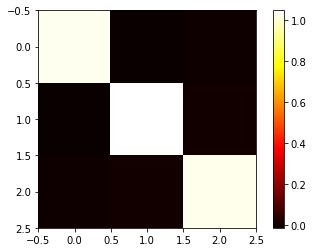

In [8]:
pcs = [e.layers[-2].weights[0] for e in encoders]
pcs = tf.concat(pcs, axis=1)
I = (tf.transpose(pcs) @ pcs)
print("Dot product of all encoder weights:\n", np.round(I, 5))
print("===> Weights are neither orthogonal nor unit norm.")

fig, ax = plt.subplots()
Z = tf.subtract(Z, tf.reduce_mean(Z, axis=0))
Z_cov = (tf.transpose(Z) @ Z) / (nsamples-1)
print("Cov of latent activations:\n", Z_cov)
plt.imshow(Z_cov, cmap='hot')
plt.colorbar();
print("===> (Mostly) uncorrelated latent activation. Due to BN, the scale is different.")

### 7. Calculate MSE

In [9]:
X_pred = pcalae.predict(X)
print("MSE: ", np.square(np.subtract(X, X_pred)).mean())

MSE:  1270.67
